# 1.1 Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 283

# 2.1 Import Raw Data

In [2]:
# Read csv with raw subreddit data into dataframe
df_subreddits = pd.read_csv('./data/subreddits_raw.csv')

# 3.1 Basic Characteristics - EDA

In [3]:
# Display sample of dataset
df_subreddits.head()

,subreddit,title,score,id,url,comms_num,created_utc,body
0,nfl,How a World Cup Style Season could work for th...,1,hvxd1n,https://www.reddit.com/r/nfl/comments/hvxd1n/h...,0,1.595437e+09,I want football just as much as anyone else re...
1,nfl,2020 Offseason Review Series - The Carolina Pa...,4,hvx8z0,https://www.reddit.com/r/nfl/comments/hvx8z0/2...,1,1.595436e+09,#Team: The Carolina Panthers\n\n**Division:** ...
2,nfl,Ten best-performing NFL O-lines by expected ru...,4,hvwvr6,https://www.nfl.com/news/ten-best-performing-n...,20,1.595435e+09,NaN
3,nfl,[Ravens] “We have agreed to terms with Patrick...,26,hvwiox,https://twitter.com/ravens/status/128595932184...,11,1.595434e+09,NaN
4,nfl,Texans DT Blacklock upon signing rookie deal: ...,25,hvwgj1,https://www.nfl.com/news/texans-sign-dt-blacklock,9,1.595434e+09,NaN


In [4]:
# Display shape of dataset
df_subreddits.shape

(1961, 8)

In [5]:
# Count records by subreddit, with and without normalization
df_subreddits['subreddit'].value_counts(), df_subreddits['subreddit'].value_counts(normalize = True)

(nfl         990
 patriots    971
 Name: subreddit, dtype: int64,
 nfl         0.504844
 patriots    0.495156
 Name: subreddit, dtype: float64)

In [6]:
# Display data types of dataset
df_subreddits.dtypes

subreddit       object
title           object
score            int64
id              object
url             object
comms_num        int64
created_utc    float64
body            object
dtype: object

# 3.2 Basic Characteristics - Cleaning and Modification

In [7]:
# Convert created_utc from epoch second to a datetime
# Conversion adapted from:
# https://stackoverflow.com/questions/12400256/converting-epoch-time-into-the-datetime
df_subreddits['created_utc'] = df_subreddits['created_utc'].map(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
# Convert created_utc to datetime data type
df_subreddits['created_utc'] = pd.to_datetime(df_subreddits['created_utc'])

In [8]:
# Add a column for posting hour
df_subreddits['posting_hour_utc'] = df_subreddits['created_utc'].map(lambda time: time.hour)

In [9]:
# Display data types of dataset
df_subreddits.dtypes

subreddit                   object
title                       object
score                        int64
id                          object
url                         object
comms_num                    int64
created_utc         datetime64[ns]
body                        object
posting_hour_utc             int64
dtype: object

# 4.1 Null Values - EDA

In [10]:
# Count frequency of null values
df_subreddits.isna().sum()

subreddit              0
title                  0
score                  0
id                     0
url                    0
comms_num              0
created_utc            0
body                1664
posting_hour_utc       0
dtype: int64

In [11]:
# Search for records with null body values with reddit.com in the url.
# Body appears to mostly be null on link posts, but it's possible there are some empty text posts.

# Define masks for urls including reddit and for null value in body
mask_reddit = (df_subreddits['url'].str.contains('www.reddit.com'))
mask_null = (df_subreddits['body'].isna())
# Display records that fit criteria above
df_subreddits[mask_reddit & mask_null]

,subreddit,title,score,id,url,comms_num,created_utc,body,posting_hour_utc
24,nfl,"In honor of the cancelled preseason, who are s...",13,hvnsdn,https://www.reddit.com/r/nfl/comments/hvnsdn/i...,41,2020-07-21 23:16:46,NaN,23
51,nfl,"Despite starting his career in 1935, Don Hutso...",586,hvfto2,https://www.reddit.com/r/nfl/comments/hvfto2/d...,69,2020-07-21 15:02:49,NaN,15
189,nfl,"The last #1 overall pick that wasn't a QB, DE,...",1173,hun4qm,https://www.reddit.com/r/nfl/comments/hun4qm/t...,272,2020-07-20 09:21:46,NaN,9
194,nfl,"Excluding Super Bowl victories, your team is t...",92,humef5,https://www.reddit.com/r/nfl/comments/humef5/e...,254,2020-07-20 08:39:51,NaN,8
256,nfl,"In 2003, Reebok created 8 new uniform designs ...",481,hu2afg,https://www.reddit.com/gallery/hu2afg,95,2020-07-19 09:29:29,NaN,9
298,nfl,What is the most bland NFL stadium? (Not neces...,38,htk0yo,https://www.reddit.com/r/nfl/comments/htk0yo/w...,158,2020-07-18 11:04:29,NaN,11
324,nfl,If you could pick any player from your team’s ...,16,htbsza,https://www.reddit.com/r/nfl/comments/htbsza/i...,218,2020-07-18 00:06:01,NaN,0
330,nfl,"When you think of the ""Steel Curtain"", do you ...",27,ht8myi,https://www.reddit.com/r/nfl/comments/ht8myi/w...,41,2020-07-17 20:00:16,NaN,20
479,nfl,With the addition of a third wildcard team in ...,109,hs9oqe,https://www.reddit.com/r/nfl/comments/hs9oqe/w...,106,2020-07-16 07:31:13,NaN,7
515,nfl,What teams have the most pressure on them goin...,39,hrxf7f,https://www.reddit.com/r/nfl/comments/hrxf7f/w...,130,2020-07-15 16:17:19,NaN,16


In [12]:
# Search for the inverse - non-null body values without reddit.com in the url.
# This should be empty if all non-null body posts are text posts.
df_subreddits[~mask_reddit & ~mask_null]

,subreddit,title,score,id,url,comms_num,created_utc,body,posting_hour_utc


> The only records with null body values and reddit.com in the url that do not appear to be text posts are image galleries typified by www.reddit.com/gallery.

# 4.2 Null Values - Cleaning and Modification

In [13]:
# Use null values to define posts as either text or link posts

# Create mask for posts with the reddit gallery in the url
mask_gallery = (df_subreddits['url'].str.contains('www.reddit.com/gallery'))
# Add text post column as a boolean if the body is not null
# Or if it is null and includes the reddit domain but not the gallery
df_subreddits['text_post'] = (~mask_null | (mask_reddit & ~mask_gallery & mask_null)).astype(int)

In [14]:
# Fill all null body values with empty strings
df_subreddits['body'].fillna('', inplace = True)

# 5.1 Posting Time - EDA

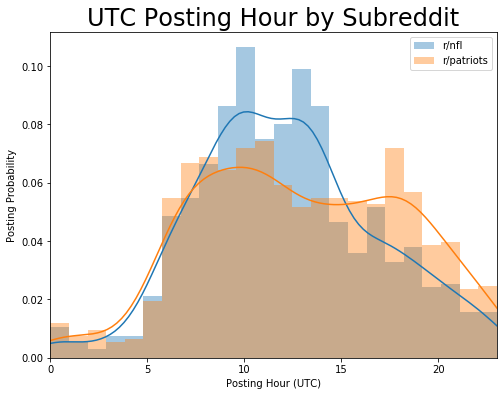

In [15]:
# Plot posting time by subreddit

# Instantiate figure and set size
plt.figure(figsize = (8,6))

# Loop through all subreddits included in the dataset and add a distribution plot for each
for sub in df_subreddits['subreddit'].unique():
    # Keep the KDE in order to normalize for subreddits with significantly different posting rates
    sns.distplot(df_subreddits.loc[df_subreddits['subreddit'] == sub, 'posting_hour_utc'],
                 bins = 24,
                 kde = True,
                 label = f'r/{sub}'
                )

# Limit x axis to the hours of the day
plt.xlim(0,23)
    
# Set title and lable names
plt.title('UTC Posting Hour by Subreddit', size = 24)
plt.xlabel('Posting Hour (UTC)')
plt.ylabel('Posting Probability')
plt.legend();

> The two chosen subreddits show significantly different posting patterns, potentially providing some predictive value in posting hour.

# 6.1 Post Type - EDA

In [16]:
# Count records by post type and by subreddit, with and without normalization
df_subreddits.groupby('subreddit')['text_post'].value_counts(), df_subreddits.groupby('subreddit')['text_post'].value_counts(normalize = True)

(subreddit  text_post
 nfl        0            807
            1            183
 patriots   0            834
            1            137
 Name: text_post, dtype: int64,
 subreddit  text_post
 nfl        0            0.815152
            1            0.184848
 patriots   0            0.858908
            1            0.141092
 Name: text_post, dtype: float64)

> There appears to be a marginal potential difference in the rate of text posts between r/nfl and r/patriots, potentially providing some predictive value.

# 6.2 Post Score - EDA

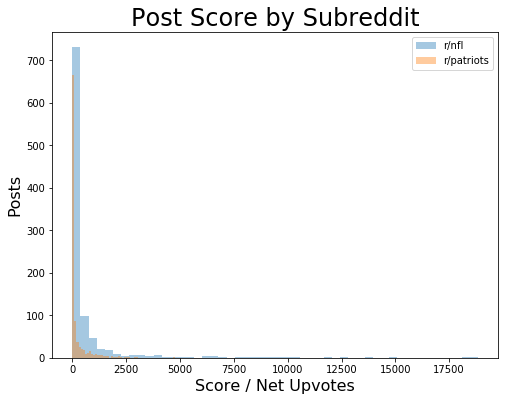

In [17]:
# Plot post scores by subreddit

# Instantiate figure and set size
plt.figure(figsize = (8,6))

# Loop through all subreddits included in the dataset and add a distribution plot for each
for sub in df_subreddits['subreddit'].unique():
    # Remove the KDE to highlight differences in posting rate and upvote rate
    sns.distplot(df_subreddits.loc[df_subreddits['subreddit'] == sub, 'score'],
                 kde = False,
                 label = f'r/{sub}'
                )

# Set title and lable names
plt.title('Post Score by Subreddit', size = 24)
plt.xlabel('Score / Net Upvotes', size = 16)
plt.ylabel('Posts', size = 16)
plt.legend();

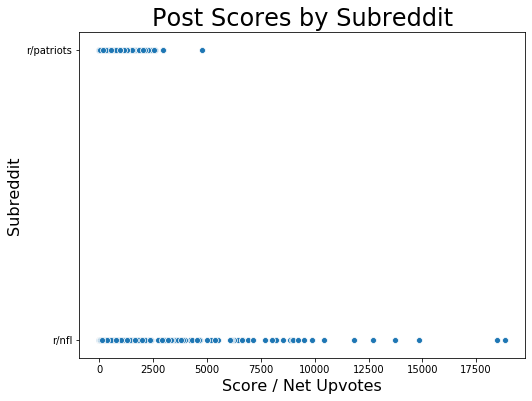

In [18]:
# Plot post scores by subreddit as a scatterplot

# Instantiate figure and set size
plt.figure(figsize = (8,6))


sns.scatterplot(df_subreddits['score'],
                df_subreddits['subreddit']
               )

# Set title and lable names
plt.title('Post Scores by Subreddit', size = 24)
plt.xlabel('Score / Net Upvotes', size = 16)
plt.ylabel('Subreddit', size = 16)
plt.yticks([0,1],['r/nfl','r/patriots']);

> The above charts show that post score provides significant predictive power, as r/nfl features many more highly scored posts than r/patriots, even if both are significantly skewed towards lower scores. The distributions are very similar, meaning any form of normalization would likely eliminate this benefit.

# 7.1 Post Comments - EDA

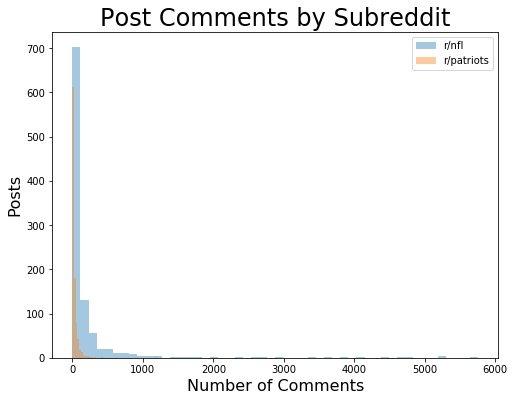

In [19]:
# Plot post scores by subreddit

# Instantiate figure and set size
plt.figure(figsize = (8,6))

# Loop through all subreddits included in the dataset and add a distribution plot for each
for sub in df_subreddits['subreddit'].unique():
    # Remove the KDE to highlight differences in posting rate and upvote rate
    sns.distplot(df_subreddits.loc[df_subreddits['subreddit'] == sub, 'comms_num'],
                 kde = False,
                 label = f'r/{sub}'
                )

# Set title and lable names
plt.title('Post Comments by Subreddit', size = 24)
plt.xlabel('Number of Comments', size = 16)
plt.ylabel('Posts', size = 16)
plt.legend();

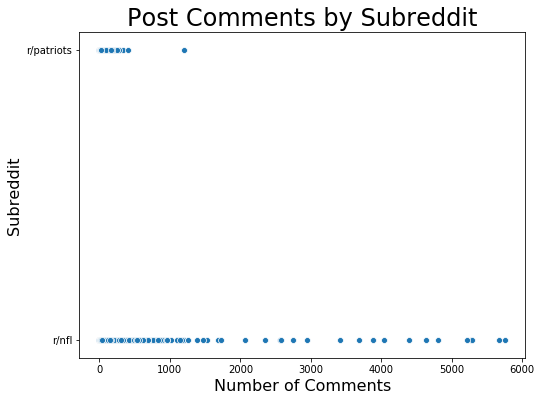

In [20]:
# Plot post scores by subreddit as a scatterplot

# Instantiate figure and set size
plt.figure(figsize = (8,6))


sns.scatterplot(df_subreddits['comms_num'],
                df_subreddits['subreddit']
               )

# Set title and lable names
plt.title('Post Comments by Subreddit', size = 24)
plt.xlabel('Number of Comments', size = 16)
plt.ylabel('Subreddit', size = 16)
plt.yticks([0,1],['r/nfl','r/patriots']);

> Similar to the post scores, there is a clear difference in the range of post comments between the two subreddits, suggesting it could provide some added predictive power. The distributions are very similar, meaning any form of normalization would likely eliminate this benefit.

# 8.1 Simplified URL - Engineering

In [21]:
# Create a new column that strips the url column down to just the domain
# Approach taken from:
# https://stackoverflow.com/questions/14625693/find-http-and-or-www-and-strip-from-domain-leaving-domain-com

# Create new column by replacing all url roots
df_subreddits['url_clean'] = df_subreddits['url'].str.replace('http://','').str.replace('https://','').str.replace('www.','')

#Remove all trailing paths
df_subreddits['url_clean'] = df_subreddits['url_clean'].map(lambda x: x.split('/')[0])

# 8.2 Simplified URL - EDA

In [22]:
# Count unique values for each url column by subreddit
df_uniques = pd.DataFrame()
df_uniques['base_url'] = df_subreddits.groupby('subreddit')['url'].nunique()
df_uniques['clean_url'] = df_subreddits.groupby('subreddit')['url_clean'].nunique()

# Append total dataset unique values
df_uniques = df_uniques.append(pd.DataFrame({'base_url': [df_subreddits['url'].nunique()],
                                            'clean_url': [df_subreddits['url_clean'].nunique()]}
                                            , index = ['all_subs']))

# Display dataframe
df_uniques

,base_url,clean_url
nfl,988,89
patriots,967,96
all_subs,1946,158


In [23]:
# Show domains that appeared more than once
repeat_urls = sum(df_subreddits['url_clean'].value_counts() > 1)
print(f'There were {repeat_urls} unique domains that appeared more than once')
df_subreddits['url_clean'].value_counts()[df_subreddits['url_clean'].value_counts() > 1]

There were 60 unique domains that appeared more than once


twitter.com                      479
reddit.com                       324
i.redd.it                        242
youtu.be                         129
v.redd.it                        105
youtube.com                       97
profootballtalk.nbcsports.com     58
espn.com                          50
nfl.com                           38
streamable.com                    30
instagram.com                     27
patriotswire.usatoday.com         18
imgur.com                         18
mobile.twitter.com                17
cbssports.com                     17
si.com                            16
i.imgur.com                       15
sports.yahoo.com                  12
nbcsports.com                     11
weei.radio.com                    10
musketfire.com                     9
clnsmedia.com                      9
patspulpit.com                     9
heavy.com                          8
theringer.com                      7
nesn.com                           7
bleacherreport.com                 7
w

> While the base URLs are nearly unique within the raw dataset, these condense to only around 160 domains between the two subreddits. Given the number of regionally-specific news outlets included within these sites, there could be some modest predictive power from these cleaned urls.

# 9.1 Word Vectors - Engineering

In [24]:
# Combine all text columns into a single column for vectorizing
df_subreddits['all_text'] = df_subreddits['title'] + ' ' + df_subreddits['body'] + ' ' + df_subreddits['url_clean']

In [25]:
# Define initial stop words list
stops = stopwords.words('english')

# Add custom stop words based on EDA below
stops.extend(['com','https','http'])

# Convert stop list to a set
stops = set(stops)

# Instantiate count vectorizer with desired hyperparameters
# Excluding min and max document frequency for EDA purposes
cv_reddit = CountVectorizer(analyzer = 'word',
                            strip_accents = 'unicode',
                            lowercase = True,
                            stop_words = stops,
                            ngram_range = (1,3)
                           )

# Fit and transform vectorizer to entire dataset
ar_vector = cv_reddit.fit_transform(df_subreddits['all_text'])

# Convert transformed status into a dataframe
df_vector = pd.DataFrame(ar_vector.toarray(), columns = cv_reddit.get_feature_names())

In [26]:
# Confirm data looks as expected

# Print the shape of the two dataframes
print(df_subreddits.shape, df_vector.shape)

# Display top of vector dataframe
df_vector.head()

(1961, 12) (1961, 134717)


,00,00 2004,00 2004 pro,00 48,00 48 week,00 4th,00 4th quarter,00 59,00 59 redd,00 ever,...,øf łist øf,øne,øne øf,øne øf thøse,łetsgøpats,łetsgøpats welcome,łetsgøpats welcome new,łist,łist øf,łist øf things
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Recreate vector dataframe merged with original dataframe
df_vector = pd.merge(df_subreddits, df_vector, left_index = True, right_index = True)

# 9.2 Word Vectors - EDA

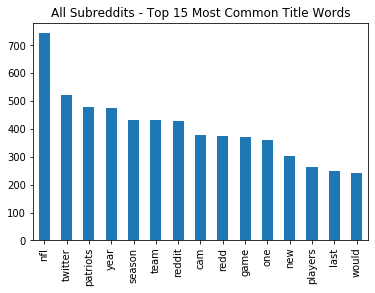

In [28]:
# Chart top 15 most common words across both subreddits
df_vector.iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('All Subreddits - Top 15 Most Common Title Words');

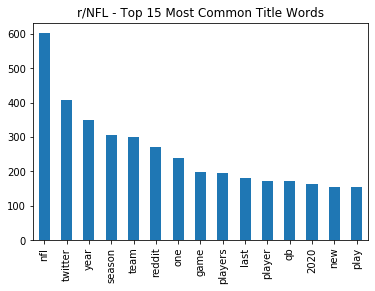

In [29]:
# Chart top 15 most common words in r/nfl
df_vector[df_vector['subreddit_x'] == 'nfl'].iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('r/NFL - Top 15 Most Common Title Words');

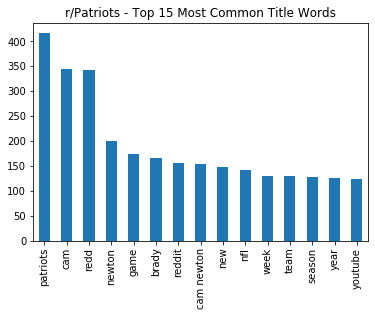

In [30]:
# Chart top 15 most common words in r/nfl
df_vector[df_vector['subreddit_x'] == 'patriots'].iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('r/Patriots - Top 15 Most Common Title Words');

> The top words from the two subreddits are unsurprisingly quite different, with the team-specific subreddit focusing heavily on the team itself and notable players. Some stop words were identified in the initial run and then removed above: com, https, http. These were removed from the url column, but not the body.

# 10.1 Word Frequency Vectors - Engineering

In [31]:
# Instantiate count vectorizer with desired hyperparameters
# Excluding min and max document frequency for EDA purposes
tf_reddit = TfidfVectorizer(analyzer = 'word',
                            strip_accents = 'unicode',
                            lowercase = True,
                            stop_words = stops,
                            ngram_range = (1,3)
                           )

# Fit and transform vectorizer to entire dataset
ar_tfvector = tf_reddit.fit_transform(df_subreddits['all_text'])

# Convert transformed status into a dataframe
df_tfvector = pd.DataFrame(ar_tfvector.toarray(), columns = tf_reddit.get_feature_names())

In [32]:
# Confirm data looks as expected

# Print the shape of the two dataframes
print(df_subreddits.shape, df_tfvector.shape)

# Display top of vector dataframe
df_tfvector.head()

(1961, 12) (1961, 134717)


,00,00 2004,00 2004 pro,00 48,00 48 week,00 4th,00 4th quarter,00 59,00 59 redd,00 ever,...,øf łist øf,øne,øne øf,øne øf thøse,łetsgøpats,łetsgøpats welcome,łetsgøpats welcome new,łist,łist øf,łist øf things
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Recreate vector dataframe merged with original dataframe
df_tfvector = pd.merge(df_subreddits, df_tfvector, left_index = True, right_index = True)

# 10.2 Word Frequency Vectors - EDA

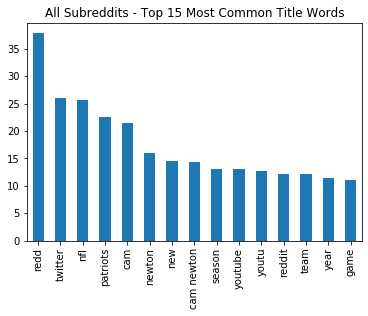

In [34]:
# Chart top 15 most common words across both subreddits
df_tfvector.iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('All Subreddits - Top 15 Most Common Title Words');

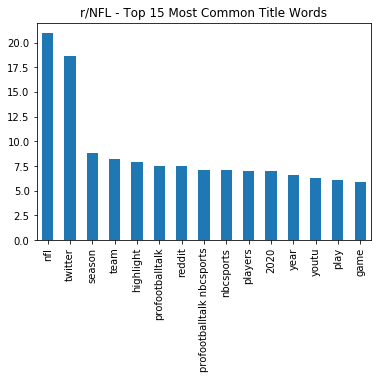

In [35]:
# Chart top 15 most common words in r/nfl
df_tfvector[df_tfvector['subreddit_x'] == 'nfl'].iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('r/NFL - Top 15 Most Common Title Words');

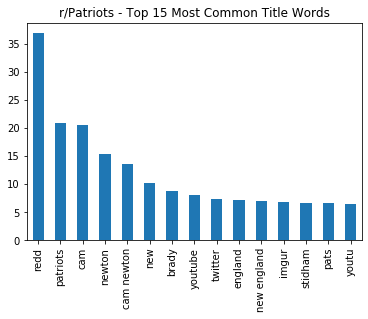

In [36]:
# Chart top 15 most common words in r/nfl
df_tfvector[df_tfvector['subreddit_x'] == 'patriots'].iloc[:,12:].sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('r/Patriots - Top 15 Most Common Title Words');

> The differences once again center around the team name and players specifically on the team, but the TF-IDF approach highlighted some less frequently mentioned players, potentially increasing its utility relative to a simple count vectorizer.

# 11.1 Parameter Testing - Data Preparation

Because the vectorizer cannot be included in a grid search if we also intend to use other columns that are not getting vectorized, this step establishes the standard set of parameters to be used by the count vectorizer.

In [37]:
# Set X equal to the combined text column for
X = df_subreddits['all_text']
# Set y equal to the subreddit
y = df_subreddits['subreddit']

In [38]:
# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# 11.2 Parameter Testing - Count Vectorizer


In [39]:
# Define standard vectorizer parameters
params_test = {
    'cvec__stop_words': [None,stops], # stops carried over from section 9.1
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__max_df': [0.99,0.95,0.9],
    'cvec__min_df': [1,2,3],
    'cvec__max_features': [4000,5000,6000]
}

# Instantiate pipeline with count vectorizer and logistic regression
pipe_test_cv = Pipeline([
    ('cvec', CountVectorizer(analyzer = 'word',
                             strip_accents = 'unicode',
                             lowercase = True)),
    ('logreg', LogisticRegression())
])

# Instantiate grid search for count vectorizer testing
grid_test_cv = GridSearchCV(pipe_test_cv,
                            params_test,
                            verbose = True,
                            cv = 5)

# Fit model on only the all_text column of X to test transformation
grid_test_cv.fit(X_train, y_train)

In [40]:
# Display best cross validation score
grid_test_cv.best_score_

In [41]:
# Display best parameter set - these will be used for the count vectorized dataset
grid_test_cv.best_params_

# 11.2 Parameter Testing - TF-IDF

In [42]:
# Define standard vectorizer parameters
# Initial run parameters are included in comments
params_test = {
    'tfidf__stop_words': [None], # [None, stops], # stops carried over from section 9.1
    'tfidf__ngram_range': [(1,2)], # [(1,1),(1,2),(1,3)],
    'tfidf__max_df': [0.99], # [0.99,0.95,0.9],
    'tfidf__min_df': [2], # [1,2,3],
    'tfidf__max_features': [6000, 7000, 8000] # [4000,5000,6000]
}

# Instantiate pipeline with TF-IDF vectorizer and logistic regression
pipe_test_tf = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = 'word',
                              strip_accents = 'unicode',
                              lowercase = True)),
    ('logreg', LogisticRegression())
])

# Instantiate grid search for count vectorizer testing
grid_test_tf = GridSearchCV(pipe_test_tf,
                            params_test,
                            verbose = True,
                            cv = 5)

# Fit model on only the all_text column of X to test transformation
grid_test_tf.fit(X_train, y_train)

In [43]:
# Display best cross validation score
grid_test_tf.best_score_

In [44]:
# Display best parameter set - these will be used for the count vectorized dataset
grid_test_tf.best_params_

The best parameters for both of the above tests proved to importantly different, though between both test models there was only one parameter (tfidf_max_features) requiring additional testing. The final parameters for both vectorization methods are listed below:

***Count Vectorizer***

```
{'max_df': 0.99,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'stop_words': stops
 }
 ```

***TF-IDF***

``` 
 {'tfidf__max_df': 0.99,
 'tfidf__max_features': 6000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}
 ```

# 12.1 Final Data - Preparation

In [45]:
# Convert the cleaned url column into dummy variables rather than text to avoid treating like comparable text
# For instance, this avoids conflating "nfl.com" links with references to "nfl" within the title
df_subreddits = pd.get_dummies(df_subreddits, columns = ['url_clean'], prefix = 'link', drop_first = False)

# Drop "link_reddit.com" rather than first column
df_subreddits.drop(columns = ['link_reddit.com'], inplace = True)

# Re-combine all remaining text columns into a new combined column for vectorizing
df_subreddits['all_text'] = df_subreddits['title'] + ' ' + df_subreddits['body']

# Drop original text columns
df_subreddits.drop(columns = ['title','body','url'], inplace = True)

# 12.2 Final Data - Vectorize

In [54]:
# Create final count vectorized dataset

# Instantiate count vectorizer with desired hyperparameters
cv_reddit = CountVectorizer(analyzer = 'word',
                            strip_accents = 'unicode',
                            lowercase = True,
                            stop_words = stops,
                            ngram_range = (1,1),
                            max_df = 0.99,
                            max_features = 5000,
                            min_df = 1
                           )

# Fit vectorizer to the training data and transform entire dataset
cv_reddit.fit(X_train)
ar_vector = cv_reddit.transform(df_subreddits['all_text'])

# Convert transformed status into a dataframe
df_vector = pd.DataFrame(ar_vector.toarray(), columns = cv_reddit.get_feature_names())

# Recreate vector dataframe merged with original dataframe
df_vector = pd.merge(df_subreddits.drop(columns = 'all_text'), df_vector, left_index = True, right_index = True)

In [55]:
# Create final TF-IDF vectorized dataset

# Instantiate count vectorizer with desired hyperparameters
tf_reddit = TfidfVectorizer(analyzer = 'word',
                            strip_accents = 'unicode',
                            lowercase = True,
                            stop_words = None,
                            ngram_range = (1,2),
                            max_df = 0.99,
                            max_features = 6000,
                            min_df = 2
                           )

# Fit vectorizer to the training data and transform entire dataset
tf_reddit.fit(X_train)
ar_tfvector = tf_reddit.transform(df_subreddits['all_text'])

# Convert transformed status into a dataframe
df_tfvector = pd.DataFrame(ar_tfvector.toarray(), columns = tf_reddit.get_feature_names())

# Recreate vector dataframe merged with original dataframe
df_tfvector = pd.merge(df_subreddits.drop(columns = 'all_text'), df_tfvector, left_index = True, right_index = True)

In [63]:
# Rename duplicated columns taken from original dataset
df_vector.rename(columns = {
    'subreddit_x': 'post_subreddit',
    'score_x': 'post_score',
    'id_x': 'post_id'
},inplace = True)

df_tfvector.rename(columns = {
    'subreddit_x': 'post_subreddit',
    'score_x': 'post_score',
    'id_x': 'post_id'
},inplace = True)

# 12.3 Final Data - Export

In [66]:
# Write cleaned dataset without vectorized data so that models can test between different vectorizer parameters
df_subreddits.to_csv('./data/subreddits_clean.csv', index = False)
df_vector.to_csv('./data/subreddits_count.csv', index = False)
df_tfvector.to_csv('./data/subreddits_tfidf.csv', index = False)